In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature
from scipy.fft import fft, fftfreq

from typing import Tuple
import polars as pl
import pandas as pd

In [3]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"
DOUBLE_COL_FIG_SIZE = (15, 5)

In [4]:
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
    feature=Feature.PRECIPITATION
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
    feature=Feature.PRECIPITATION
)

/tmp/ipykernel_25060/3107389677.py:14: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  mean_1 -= mean_1.mean()
/tmp/ipykernel_25060/3107389677.py:14: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  mean_1 -= mean_1.mean()
/tmp/ipykernel_25060/3107389677.py:16: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  mean_2 -= mean_2.mean()
/tmp/ipykernel_25060/3107389677.py:16: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  mean_2 -= mean_2.mean()
/tmp/ipykernel_25060/3107389677.py:19: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  std_1 -= std_1.mean()
/tmp/ipykernel_25060/3107389677.py:19: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  std_1 -= std_1.mean()
/tmp/ipykernel_25060/3107389677.py:21: PerformanceWarning: Adding/

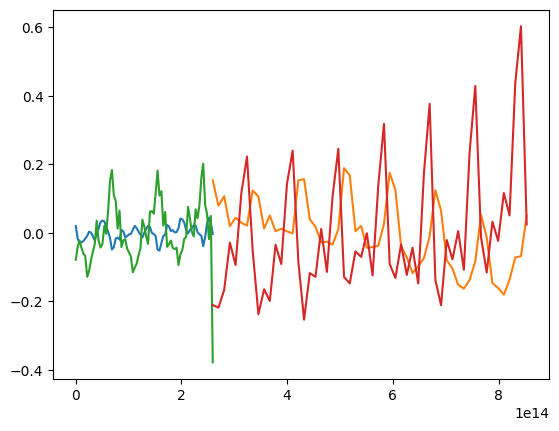

In [56]:
merge_1 = dataset_model_1.get_merge()
merge_2 = dataset_model_2.get_merge()

# set call time for all to 00:00
merge_1["call_time"] = merge_1["call_time"].dt.normalize()
merge_2["call_time"] = merge_2["call_time"].dt.normalize()
# insert time delta column
time_delta = merge_1["time"] - merge_1["call_time"]
merge_1.insert(len(merge_1.columns), "time_delta", time_delta)
time_delta = merge_2["time"] - merge_2["call_time"]
merge_2.insert(len(merge_2.columns), "time_delta", time_delta)

mean_1 = merge_1.groupby("time_delta").mean()
mean_1 -= mean_1.mean()
mean_2 = merge_2.groupby("time_delta").mean()
mean_2 -= mean_2.mean()

std_1 = merge_1.groupby("time_delta").std()
std_1 -= std_1.mean()
std_2 = merge_2.groupby("time_delta").std()
std_2 -= std_2.mean()

plt.plot(mean_1.index, mean_1["precipitation_error"])
plt.plot(mean_2.index, mean_2["precipitation_error"])
plt.plot(std_1.index, std_1["precipitation_error"])
plt.plot(std_2.index, std_2["precipitation_error"])

In [57]:
def do_fft(time_series: np.ndarray, period: float = 1) -> Tuple[np.ndarray, np.ndarray]:
    """perform fft on given time series

    Args:
        time_series (np.ndarray): shape (num_series, length of series)
        period (float, optional): _description_. Defaults to 1.

    Returns:
        Tuple[np.ndarray, np.ndarray]: _description_
    """
    # Number of sample points
    N = time_series.shape[-1]
    # sample spacing

    result = np.empty((time_series.shape[0], time_series.shape[1] // 2))
    for idx, station_error in enumerate(tqdm(time_series, desc="Do fft")):
        yf = fft(station_error)
        yf = 2.0 / N * np.abs(yf[0 : N // 2])
        result[idx] = yf

    xf = fftfreq(N, period)[: N // 2]
    return xf, result


Do fft: 100%|██████████| 1/1 [00:00<00:00, 3512.82it/s]


mean_1
Dominating frequency:  2.958904109589041
Relative Amplitude:  0.13096399097154376


Do fft: 100%|██████████| 1/1 [00:00<00:00, 8439.24it/s]


mean_2
Dominating frequency:  1.0
Relative Amplitude:  0.20423390942649314


Do fft: 100%|██████████| 1/1 [00:00<00:00, 8456.26it/s]


std_1
Dominating frequency:  0.9863013698630136
Relative Amplitude:  0.16612346018568663


Do fft: 100%|██████████| 1/1 [00:00<00:00, 4928.68it/s]

std_2
Dominating frequency:  0.3287671232876712
Relative Amplitude:  0.16612346018568663


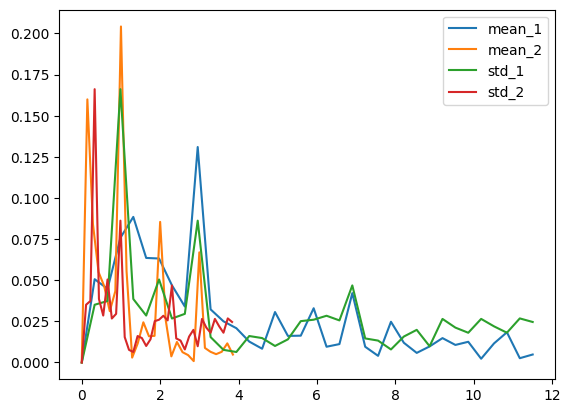

In [71]:
fig, ax  = plt.subplots()
# for series, label in zip([std_1, std_1], ["std_1", "std_2"]):
for series, label in zip([mean_1, mean_2, std_1, std_1], ["mean_1", "mean_2", "std_1", "std_2"]):
    xf, yf = do_fft(series["precipitation_error"].values[None])
    xf *= 24
    yf /= yf.sum()
    if "2" in label:
        xf /= 3
    ax.plot(xf, *yf, label=label)

    index = np.argmax(yf)
    print(label)
    print("Dominating frequency: ", xf[index])
    print("Relative Amplitude: ", np.max(yf))

ax.legend()